In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap, xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, roc_auc_score,
                             mean_squared_error, mean_absolute_error, r2_score)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold, KFold)
import warnings, gc, os, json, random, pickle
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (9,6)

RANDOM_STATE = 42
READ_SIZE     = 100_000          
N_JOBS        = -1               
TEST_SIZE     = 0.2


In [2]:
train = pd.read_csv("Training Data.csv", nrows=READ_SIZE)
print(f"shape: {train.shape}")
display(train.head())
display(train.describe(include='all').T)

#######################################################################
# 2. Чистка: пропуски, нефичевые столбцы, типы
#######################################################################
train.drop(columns=["Id"], inplace=True)        # уникальный id не несёт информации
# Пропусков нет – проверяем:
assert train.isna().sum().sum() == 0

num_cols = ['Income','Age','Experience','CURRENT_JOB_YRS','CURRENT_HOUSE_YRS']
cat_cols = [c for c in train.columns if c not in num_cols + ['Risk_Flag']]


shape: (100000, 13)


,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,100000.0,NaN,NaN,NaN,50000.5,28867.657797,1.0,25000.75,50000.5,75000.25,100000.0
Income,100000.0,NaN,NaN,NaN,5001617.02566,2876393.52118,10310.0,2507092.0,5004938.0,7477502.0,9999180.0
Age,100000.0,NaN,NaN,NaN,49.9954,17.056051,21.0,35.0,50.0,65.0,79.0
Experience,100000.0,NaN,NaN,NaN,10.11075,5.996007,0.0,5.0,10.0,15.0,20.0
Married/Single,100000,2,single,89763,NaN,NaN,NaN,NaN,NaN,NaN,NaN
House_Ownership,100000,3,rented,92088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Car_Ownership,100000,2,no,69665,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Profession,100000,51,Physician,2426,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CITY,100000,317,Vijayanagaram,519,NaN,NaN,NaN,NaN,NaN,NaN,NaN
STATE,100000,29,Uttar_Pradesh,11255,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
X_full, y_full = train.drop('Risk_Flag', axis=1), train['Risk_Flag']
X_tr, X_te, y_tr, y_te = train_test_split(
    X_full, y_full, test_size=TEST_SIZE, stratify=y_full,
    random_state=RANDOM_STATE
)


In [ ]:
encoder = ColumnTransformer([
    ('num', StandardScaler(),        num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

X_tr_enc = encoder.fit_transform(X_tr)
X_te_enc = encoder.transform(X_te)

### для CatBoost «сырые» признаки тоже нужны:
cat_idx   = [X_tr.columns.get_loc(c) for c in cat_cols]
pool_tr   = Pool(X_tr,  y_tr, cat_features=cat_idx)
pool_te   = Pool(X_te,  y_te, cat_features=cat_idx)



In [5]:
cv = StratifiedKFold(4, shuffle=True, random_state=RANDOM_STATE)

grid_ada = GridSearchCV(
    AdaBoostClassifier(random_state=RANDOM_STATE),
    param_grid = {
        "n_estimators":[100,200],
        "learning_rate":[0.05,0.1,0.2]
    }, cv=cv, scoring='roc_auc', n_jobs=N_JOBS, verbose=1
).fit(X_tr_enc, y_tr)

grid_gbc = GridSearchCV(
    GradientBoostingClassifier(random_state=RANDOM_STATE),
    param_grid = {
        "n_estimators":[100,200],
        "learning_rate":[0.05,0.1],
        "max_depth":[3,5]
    }, cv=cv, scoring='roc_auc', n_jobs=N_JOBS, verbose=1
).fit(X_tr_enc, y_tr)

grid_xgb_enc = GridSearchCV(
    xgb.XGBClassifier(
        objective='binary:logistic', eval_metric='auc',
        random_state=RANDOM_STATE, n_jobs=N_JOBS, tree_method='hist'
    ),
    param_grid = {
        "n_estimators":[200,400],
        "learning_rate":[0.05,0.1],
        "max_depth":[4,6],
        "reg_alpha":[0,0.5],
        "reg_lambda":[1,2]
    }, cv=cv, scoring='roc_auc', n_jobs=N_JOBS, verbose=1
).fit(X_tr_enc, y_tr)

grid_cat_enc = GridSearchCV(
    CatBoostClassifier(
        silent=True, random_state=RANDOM_STATE, loss_function='Logloss'
    ),
    param_grid = {
        "iterations":[300,600],
        "learning_rate":[0.05,0.1],
        "depth":[4,6,8],
        "l2_leaf_reg":[1,3,5]
    }, cv=cv, scoring='roc_auc', n_jobs=N_JOBS, verbose=1
).fit(X_tr_enc, y_tr)


Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Fitting 4 folds for each of 32 candidates, totalling 128 fits
Fitting 4 folds for each of 36 candidates, totalling 144 fits


In [6]:
best_xgb_raw = xgb.XGBClassifier(
    **grid_xgb_enc.best_params_,          
    objective        = "binary:logistic",
    eval_metric      = "auc",             
    tree_method      = "hist",
    random_state     = RANDOM_STATE,
    n_jobs           = N_JOBS,
    early_stopping_rounds = 50,           
    enable_categorical   = False          
)

best_xgb_raw.fit(
    X_tr_enc, y_tr,
    eval_set = [(X_te_enc, y_te)],
    verbose  = False                      
)



best_cat_raw = CatBoostClassifier(
    **grid_cat_enc.best_params_,
    silent=True, random_state=RANDOM_STATE, loss_function='Logloss'
).fit(pool_tr, eval_set=pool_te, early_stopping_rounds=50, verbose=False)


In [7]:
def evaluate(name, model, X, y):
    proba = model.predict_proba(X)[:,1] if hasattr(model,"predict_proba") else model.predict(X)
    preds = (proba > 0.5).astype(int)
    print(f"\n{name}\n" + "-"*len(name))
    print(classification_report(y, preds, digits=3))
    print(f"ROC-AUC: {roc_auc_score(y, proba):.4f}")

evaluate("AdaBoost (enc)",      grid_ada.best_estimator_,      X_te_enc, y_te)
evaluate("GradBoost (enc)",     grid_gbc.best_estimator_,      X_te_enc, y_te)
evaluate("XGB (enc)",           grid_xgb_enc.best_estimator_,  X_te_enc, y_te)
evaluate("CatBoost (enc)",      grid_cat_enc.best_estimator_,  X_te_enc, y_te)
evaluate("XGB (enc-raw name исправили)", best_xgb_raw, X_te_enc,         y_te)
evaluate("CatBoost (raw cat)",  best_cat_raw,                  pool_te,  y_te)


AdaBoost (enc)
--------------
              precision    recall  f1-score   support

           0      0.870     1.000     0.931     17401
           1      0.000     0.000     0.000      2599

    accuracy                          0.870     20000
   macro avg      0.435     0.500     0.465     20000
weighted avg      0.757     0.870     0.810     20000

ROC-AUC: 0.5810

GradBoost (enc)
---------------
              precision    recall  f1-score   support

           0      0.877     0.997     0.933     17401
           1      0.770     0.066     0.121      2599

    accuracy                          0.876     20000
   macro avg      0.824     0.531     0.527     20000
weighted avg      0.863     0.876     0.828     20000

ROC-AUC: 0.8621

XGB (enc)
---------
              precision    recall  f1-score   support

           0      0.888     0.993     0.938     17401
           1      0.777     0.162     0.268      2599

    accuracy                          0.885     20000
   macro av

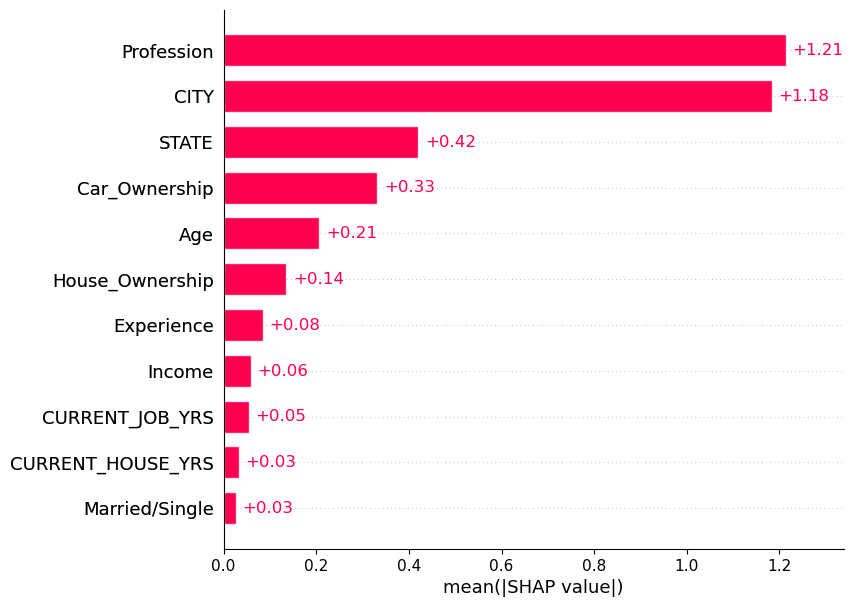

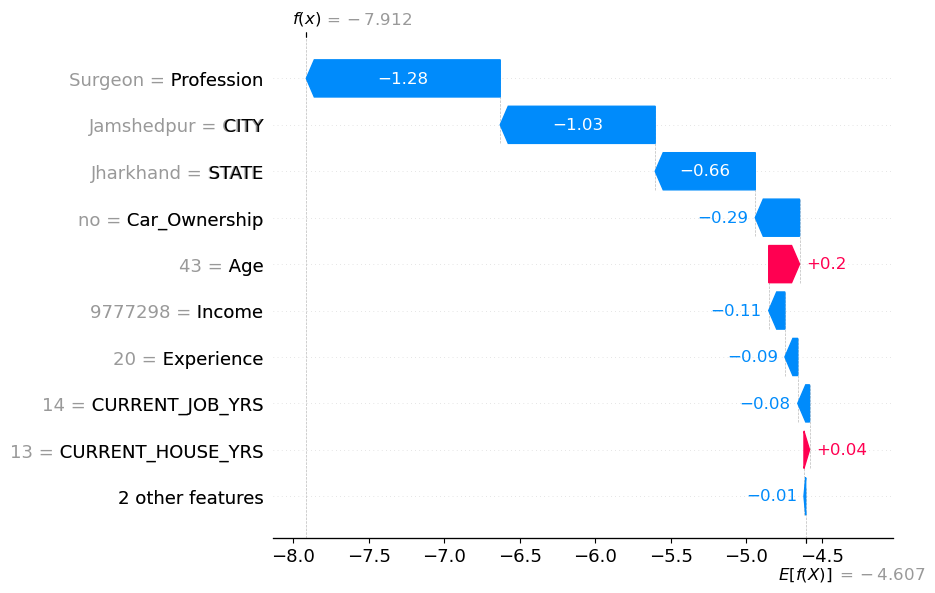

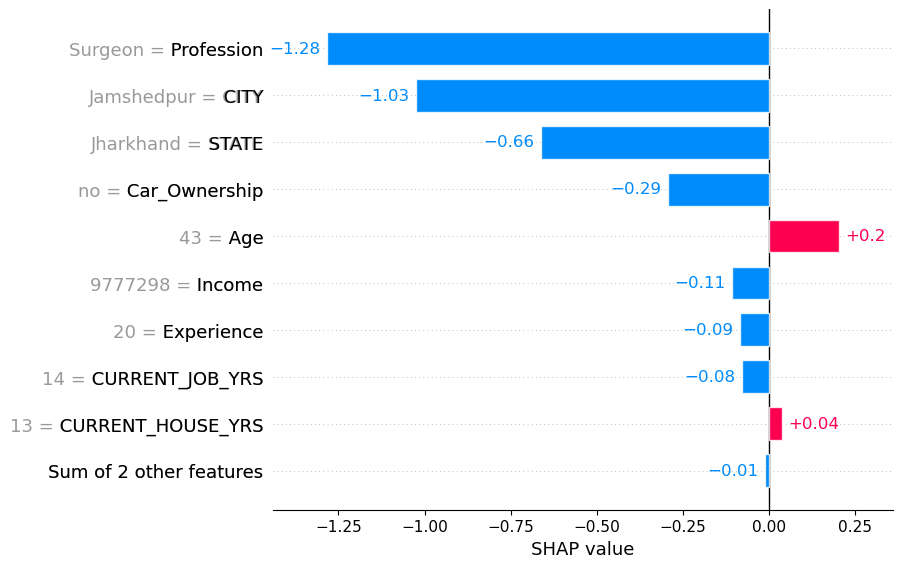

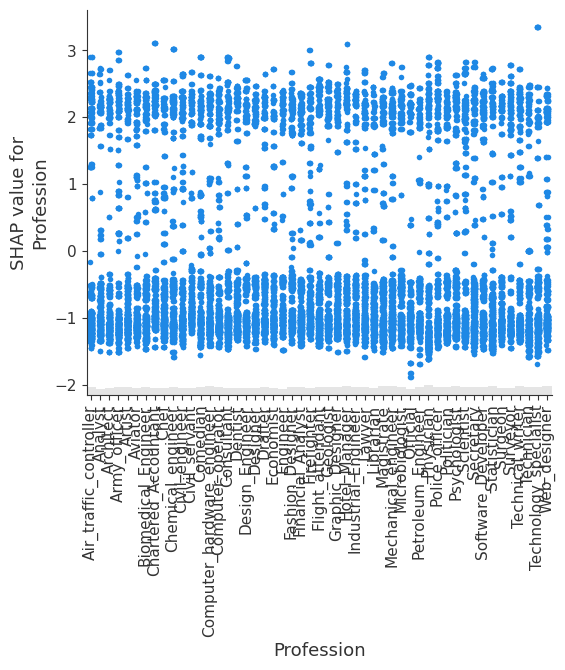

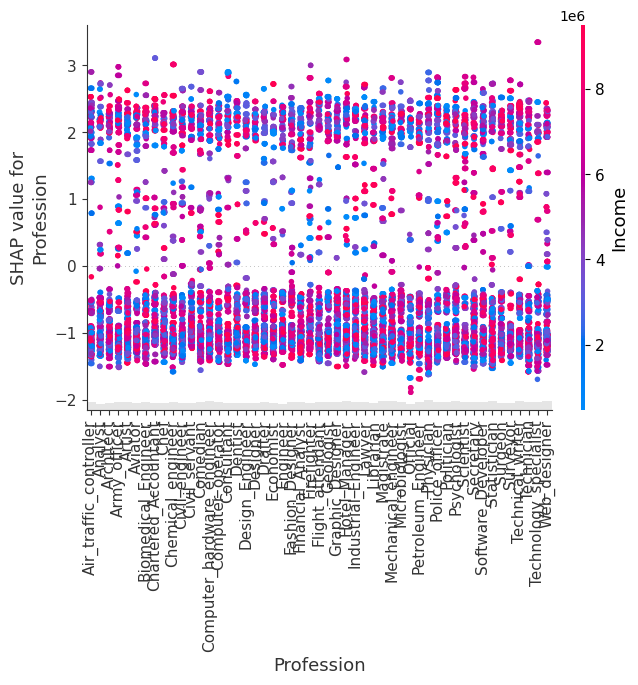

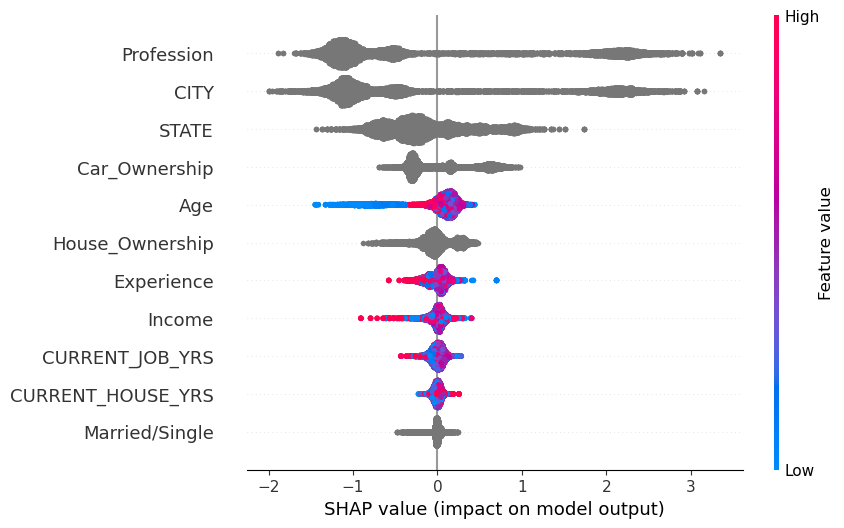

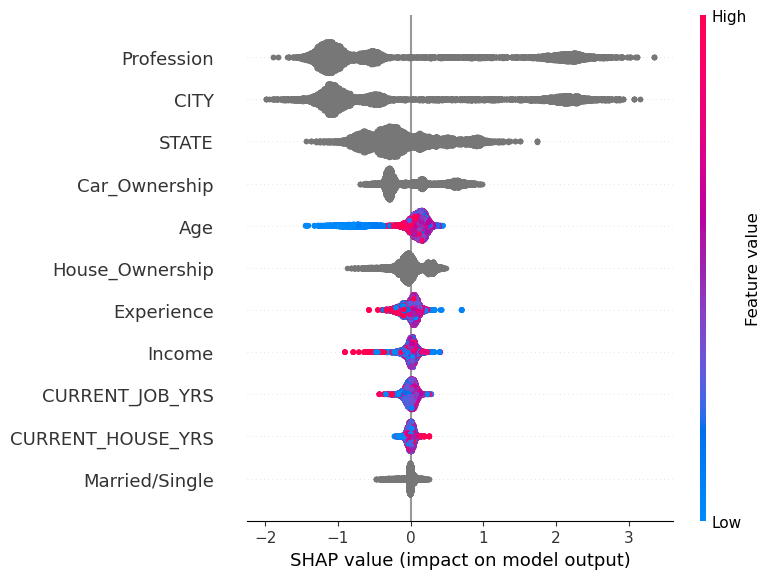

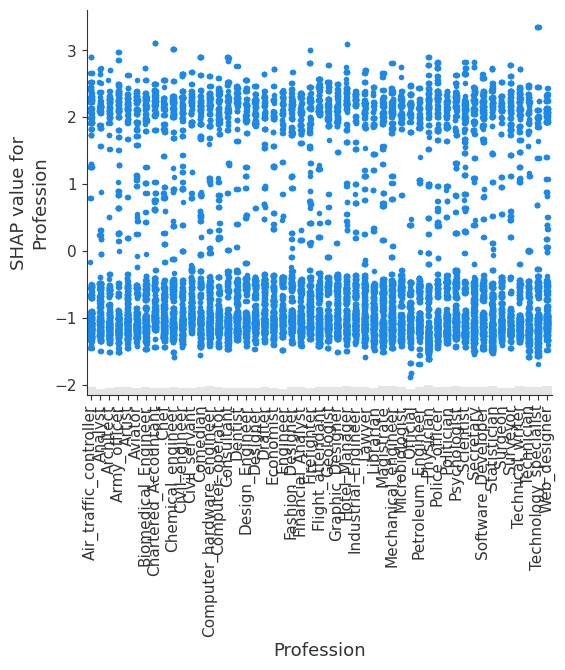

NameError: name 'shap_vals' is not defined

In [8]:
explainer = shap.Explainer(best_cat_raw)
shap_exp  = explainer(X_te)  


shap.plots.bar(shap_exp, max_display=20)

shap.plots.force(shap_exp[0])

shap.plots.force(shap_exp[:100])

shap.plots.waterfall(shap_exp[0], max_display=10)

shap.plots.bar(shap_exp[0], max_display=10)

feature_importance = np.abs(shap_exp.values).mean(0)
top_feat_idx = np.argmax(feature_importance)
top_feat_name = shap_exp.feature_names[top_feat_idx]

shap.plots.scatter(shap_exp[:, top_feat_name])

second_feat_idx = 0  # Choose another feature index
second_feat_name = shap_exp.feature_names[second_feat_idx]
shap.plots.scatter(shap_exp[:, top_feat_name], color=shap_exp[:, second_feat_name])

shap.plots.beeswarm(shap_exp, max_display=20)

shap.summary_plot(shap_exp, X_te, max_display=20)

shap.plots.scatter(shap_exp[:, top_feat_name])
# force plot для одного объекта
shap.force_plot(explainer.expected_value, shap_vals[0,:], X_te.iloc[0,:])

# force plot для среза из 100 объектов
shap.force_plot(explainer.expected_value, shap_vals[:100,:], X_te.iloc[:100,:])

# waterfall + bar для одного объекта
shap.plots.waterfall(shap.Explanation(values=shap_vals[0],
                                      base_values=explainer.expected_value,
                                      data=X_te.iloc[0]))
shap.plots.bar(shap.Explanation(values=shap_vals[0],
                                base_values=explainer.expected_value,
                                data=X_te.iloc[0]),
               max_display=10)


In [9]:
mean_abs_shap = np.abs(shap_vals).mean(0)
important_features = X_tr.columns[ mean_abs_shap > np.percentile(mean_abs_shap, 25) ]  # верхние 75 %
print(f"{len(important_features)} from {len(X_tr.columns)} kept")

pool_tr_imp = Pool(X_tr[important_features], y_tr, cat_features=[important_features.get_loc(c) for c in cat_cols if c in important_features])
pool_te_imp = Pool(X_te[important_features], y_te, cat_features=[important_features.get_loc(c) for c in cat_cols if c in important_features])

cat_imp = CatBoostClassifier(**grid_cat_enc.best_params_,
                             silent=True, random_state=RANDOM_STATE, loss_function='Logloss'
).fit(pool_tr_imp, eval_set=pool_te_imp,
      early_stopping_rounds=50, verbose=False)

evaluate("CatBoost (filtered)", cat_imp, pool_te_imp, y_te)


NameError: name 'shap_vals' is not defined

In [10]:
cat_imp.plot_tree(tree_idx=0, pool=pool_tr_imp) 

NameError: name 'cat_imp' is not defined

In [11]:
print("Data types in X_tr:")
print(X_tr.dtypes.value_counts())

for col in X_tr.columns:
    if X_tr[col].dtype == 'object' or X_tr[col].dtype == 'category':
        unique_values = X_tr[col].unique()
        if 'single' in unique_values:
            print(f"Column '{col}' contains 'single' value")

cat_features_indices = [i for i, col in enumerate(X_tr.columns) if 
                        X_tr[col].dtype == 'object' or 
                        X_tr[col].dtype == 'category']
cat_features_names = [col for col in X_tr.columns if 
                     X_tr[col].dtype == 'object' or 
                     X_tr[col].dtype == 'category']

print(f"Identified {len(cat_features_indices)} categorical features")
print("Categorical feature names:", cat_features_names[:5], "..." if len(cat_features_names) > 5 else "")

pool_tr = Pool(X_tr, y_tr, cat_features=cat_features_indices)
pool_te = Pool(X_te, yr_te if 'yr_te' in locals() else y_te, cat_features=cat_features_indices)

# Run grid search with the properly formatted data
reg_grid = GridSearchCV(
    CatBoostRegressor(
        silent=True, random_state=RANDOM_STATE, loss_function='RMSE'
    ),
    param_grid = {
        "iterations": [500, 800],
        "learning_rate": [0.05, 0.1],
        "depth": [4, 6, 8]
    },
    cv=KFold(4, shuffle=True, random_state=RANDOM_STATE),
    scoring='neg_root_mean_squared_error', 
    n_jobs=N_JOBS, 
    verbose=1
)

reg_grid.fit(X_tr, y_tr, **{"cat_features": cat_features_indices})

reg_best = reg_grid.best_estimator_

if 'Xr_te' in locals():
    test_data = Xr_te
    test_target = yr_te
else:
    test_data = X_te
    test_target = y_te

test_pool = Pool(test_data, test_target, cat_features=cat_features_indices)

# Get predictions
preds = reg_best.predict(test_data)
print("\nRegression metrics (all features)")
print(f"RMSE = {mean_squared_error(test_target, preds):.0f}")
print(f"MAE  = {mean_absolute_error(test_target, preds):.0f}")
print(f"R²   = {r2_score(test_target, preds):.4f}")

if 'important_features' in locals():
    imp_feat_indices = [i for i, col in enumerate(important_features) if 
                         X_tr[col].dtype == 'object' or 
                         X_tr[col].dtype == 'category']
    
    # Create pool objects for training with important features
    if 'Xr_tr_imp' in locals() and 'yr_tr' in locals():
        pool_tr_imp = Pool(Xr_tr_imp, yr_tr, cat_features=imp_feat_indices)
        pool_te_imp = Pool(Xr_te_imp, yr_te, cat_features=imp_feat_indices)
    else:
        Xr_tr_imp = X_tr[important_features]
        Xr_te_imp = X_te[important_features]
        pool_tr_imp = Pool(Xr_tr_imp, y_tr, cat_features=imp_feat_indices)
        pool_te_imp = Pool(Xr_te_imp, test_target, cat_features=imp_feat_indices)

    # Either train from scratch or use best parameters from grid search
    reg_imp = CatBoostRegressor(**reg_grid.best_params_,
                               silent=True, random_state=RANDOM_STATE, loss_function='RMSE')
    
    # Train on important features
    reg_imp.fit(pool_tr_imp, eval_set=pool_te_imp, early_stopping_rounds=50, verbose=False)
    
    # Predict with important features
    preds_imp = reg_imp.predict(Xr_te_imp)
    print("\nRegression metrics (filtered features)")
    print(f"RMSE = {mean_squared_error(yr_te if 'yr_te' in locals() else test_target, preds_imp):.0f}")
    print(f"MAE  = {mean_absolute_error(yr_te if 'yr_te' in locals() else test_target, preds_imp):.0f}")
    print(f"R²   = {r2_score(yr_te if 'yr_te' in locals() else test_target, preds_imp):.4f}")

    # Visualize feature importance
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 8))
    feature_importance = reg_imp.get_feature_importance()
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [important_features[i] for i in sorted_idx])
    plt.title('CatBoost Feature Importance (Filtered Regression Model)')
    plt.tight_layout()
    plt.show()

Data types in X_tr:
object    6
int64     5
Name: count, dtype: int64
Column 'Married/Single' contains 'single' value
Identified 6 categorical features
Categorical feature names: ['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY'] ...
Fitting 4 folds for each of 12 candidates, totalling 48 fits

Regression metrics (all features)
RMSE = 0
MAE  = 0
R²   = 0.6386
